In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2024-06-11 16:30:47--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71,53K  --.-KB/s    in 0,01s   

2024-06-11 16:30:47 (5,71 MB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



In [136]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score

In [137]:
df = pd.read_csv("AER_credit_card_data.csv")
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [138]:
card_values = {
    "yes": 1,
    "no": 0
}
df["card"] = df.card.map(card_values)

In [139]:
full_train, test = train_test_split(df, test_size=0.2, random_state=1)
train, val = train_test_split(full_train, test_size=0.25, random_state=1)

In [72]:
numeric = train.select_dtypes(include='number').drop(columns=["card"]).columns
for col in numeric:
    auc = roc_auc_score(train["card"], train[col])
    if  auc < 0.5:
        auc = roc_auc_score(-train["card"], train[col])
    
    print(col+": ", round(auc, 4))
    

reports:  0.7167
age:  0.524
income:  0.5908
share:  0.9892
expenditure:  0.991
dependents:  0.5328
months:  0.5294
majorcards:  0.5344
active:  0.6043


## Question 1
Which numerical variable (among the following 4) has the highest AUC? **share**

## Training the model

In [86]:
features = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [87]:
x_train = train[features]
x_val = val[features]
x_test = test[features]

dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(x_train.to_dict(orient="records"))
x_val = dv.transform(x_val.to_dict(orient="records"))

y_train, y_val, y_test = train["card"], val["card"], test["card"]

In [89]:
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
lr.fit(x_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [97]:
y_pred_val = lr.predict_proba(x_val)[:,1]
round(roc_auc_score(y_val, y_pred_val), 3)

0.995

## Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits) **0.995**

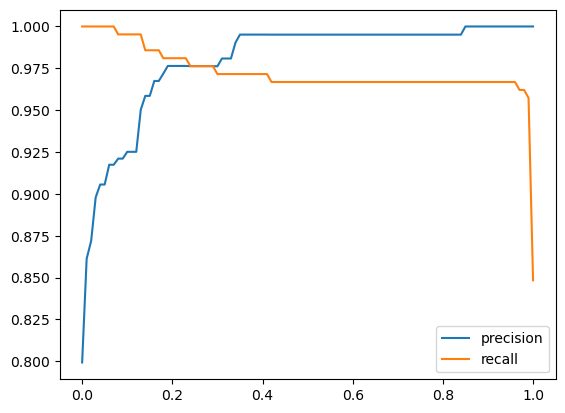

In [121]:
precision = []
recall = []
ths = np.arange(0.0, 1.01, 0.01)
for th in ths:
    y_pred_val = lr.predict_proba(x_val)[:,1]
    y_pred_val = (y_pred_val>=th).astype(int)
    precision.append(precision_score(y_val, y_pred_val))
    recall.append(recall_score(y_val, y_pred_val))
    
plt.plot(ths, precision, label='precision')
plt.plot(ths, recall, label='recall')

plt.legend()
plt.show()

## Question 3
At which threshold precision and recall curves intersect? **0.3**

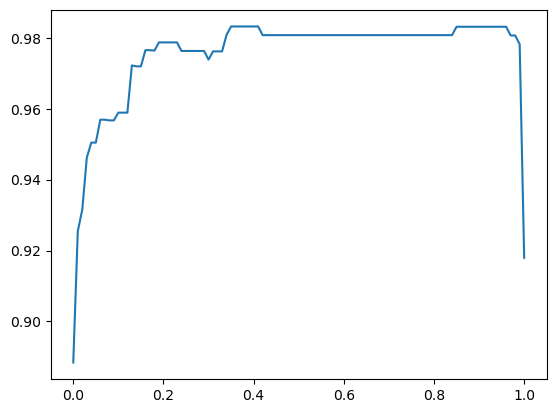

In [126]:
f1_scores = []
ths = np.arange(0.0, 1.01, 0.01)
for th in ths:
    y_pred_val = lr.predict_proba(x_val)[:,1]
    y_pred_val = (y_pred_val>=th).astype(int)
    precision = precision_score(y_val, y_pred_val)
    recall = recall_score(y_val, y_pred_val)
    f1 = 2*((precision*recall)/(precision+recall))
    f1_scores.append(f1)
    
plt.plot(ths, f1_scores)
plt.show()

## Question 4
At which threshold F1 is maximal? **0.4**

In [134]:
full_train = dv.transform(full_train[features].to_dict(orient="records"))

In [135]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [145]:
aucs = []
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
for train_idx, val_idx in tqdm(kf.split(full_train)):
    x_train = full_train.iloc[train_idx]
    x_val = full_train.iloc[val_idx]
    
    
    y_train = x_train.card.values
    y_val = x_val.card.values
    
    x_train = dv.transform(x_train[features].to_dict(orient="records"))
    x_val = dv.transform(x_val[features].to_dict(orient="records"))                       
    
    lr.fit(x_train, y_train)
    y_pred_val = lr.predict_proba(x_val)[:,1]
    aucs.append(roc_auc_score(y_val, y_pred_val))

0it [00:00, ?it/s]

In [149]:
round(np.std(aucs), 3)

0.003

## Question 5
How large is standard devidation of the AUC scores across different folds? **0.003**

In [158]:
for c in tqdm([0.01, 0.1, 1, 10]):
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    aucs = []
    lr = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    for train_idx, val_idx in kf.split(full_train):
        x_train = full_train.iloc[train_idx]
        x_val = full_train.iloc[val_idx]


        y_train = x_train.card.values
        y_val = x_val.card.values

        x_train = dv.transform(x_train[features].to_dict(orient="records"))
        x_val = dv.transform(x_val[features].to_dict(orient="records"))                       

        lr.fit(x_train, y_train)
        y_pred_val = lr.predict_proba(x_val)[:,1]
        aucs.append(roc_auc_score(y_val, y_pred_val))
    print(c,": ", round(np.mean(aucs), 3), "+", round(np.std(aucs), 4))

  0%|          | 0/4 [00:00<?, ?it/s]

0.01 :  0.992 + 0.0056
0.1 :  0.995 + 0.004
1 :  0.996 + 0.0027
10 :  0.996 + 0.0028


Question 6
Which C leads to the best mean score? **1**